In [1]:
# 1) Imports & global settings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

import joblib

# plot defaults
%matplotlib inline
sns.set(style='whitegrid')

In [2]:
# 2) Load dataset and quick overview
path = r"C:\Users\shrey\Students_Score_Prediction\data\Students Performance.csv"
df = pd.read_csv(path)

print('Shape:', df.shape)
display(df.head())
print('\nInfo:')
print(df.info())

# Normalize column names for easier access in code
original_columns = df.columns.tolist()
df.columns = [c.strip().lower().replace(' ', '_').replace('/', '_') for c in df.columns]
print('\nRenamed columns:')
print(df.columns.tolist())


Shape: (1000, 11)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,Attendance,Hours_Studied,Final_Score
0,female,group B,bachelor's degree,standard,none,72,72,74,71,4.4,72.7
1,female,group C,some college,standard,completed,69,90,88,99,9.6,82.3
2,female,group B,master's degree,standard,none,90,95,93,79,7.6,92.7
3,male,group A,associate's degree,free/reduced,none,47,57,44,70,6.4,49.3
4,male,group C,some college,standard,none,76,78,75,72,2.4,76.3



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null   object 
 1   race/ethnicity               1000 non-null   object 
 2   parental level of education  1000 non-null   object 
 3   lunch                        1000 non-null   object 
 4   test preparation course      1000 non-null   object 
 5   math score                   1000 non-null   int64  
 6   reading score                1000 non-null   int64  
 7   writing score                1000 non-null   int64  
 8   Attendance                   1000 non-null   int64  
 9   Hours_Studied                1000 non-null   float64
 10  Final_Score                  1000 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 86.1+ KB
None

Renamed columns:
['gender', 'race_ethnicity', 'parental_level_of


Missing values per column:
gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
attendance                     0
hours_studied                  0
final_score                    0
avg_score                      0
dtype: int64

Numeric summary:


,math_score,reading_score,writing_score,attendance,hours_studied,final_score,avg_score
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000,78.228000,5.413500,67.769800,67.770667
std,15.16308,14.600192,15.195657,9.735543,2.630701,14.257197,14.257326
min,0.00000,17.000000,10.000000,60.000000,1.000000,9.000000,9.000000
25%,57.00000,59.000000,57.750000,70.000000,3.100000,58.300000,58.333333
50%,66.00000,70.000000,69.000000,78.000000,5.500000,68.300000,68.333333
75%,77.00000,79.000000,79.000000,84.000000,7.700000,77.700000,77.666667
max,100.00000,100.000000,100.000000,100.000000,10.000000,100.000000,100.000000



Value counts for gender
gender
female    518
male      482
Name: count, dtype: int64

Value counts for race_ethnicity
race_ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64

Value counts for parental_level_of_education
parental_level_of_education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64

Value counts for lunch
lunch
standard        645
free/reduced    355
Name: count, dtype: int64

Value counts for test_preparation_course
test_preparation_course
none         642
completed    358
Name: count, dtype: int64


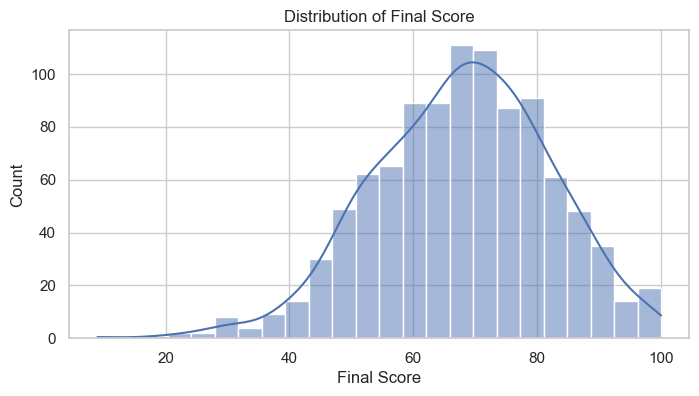

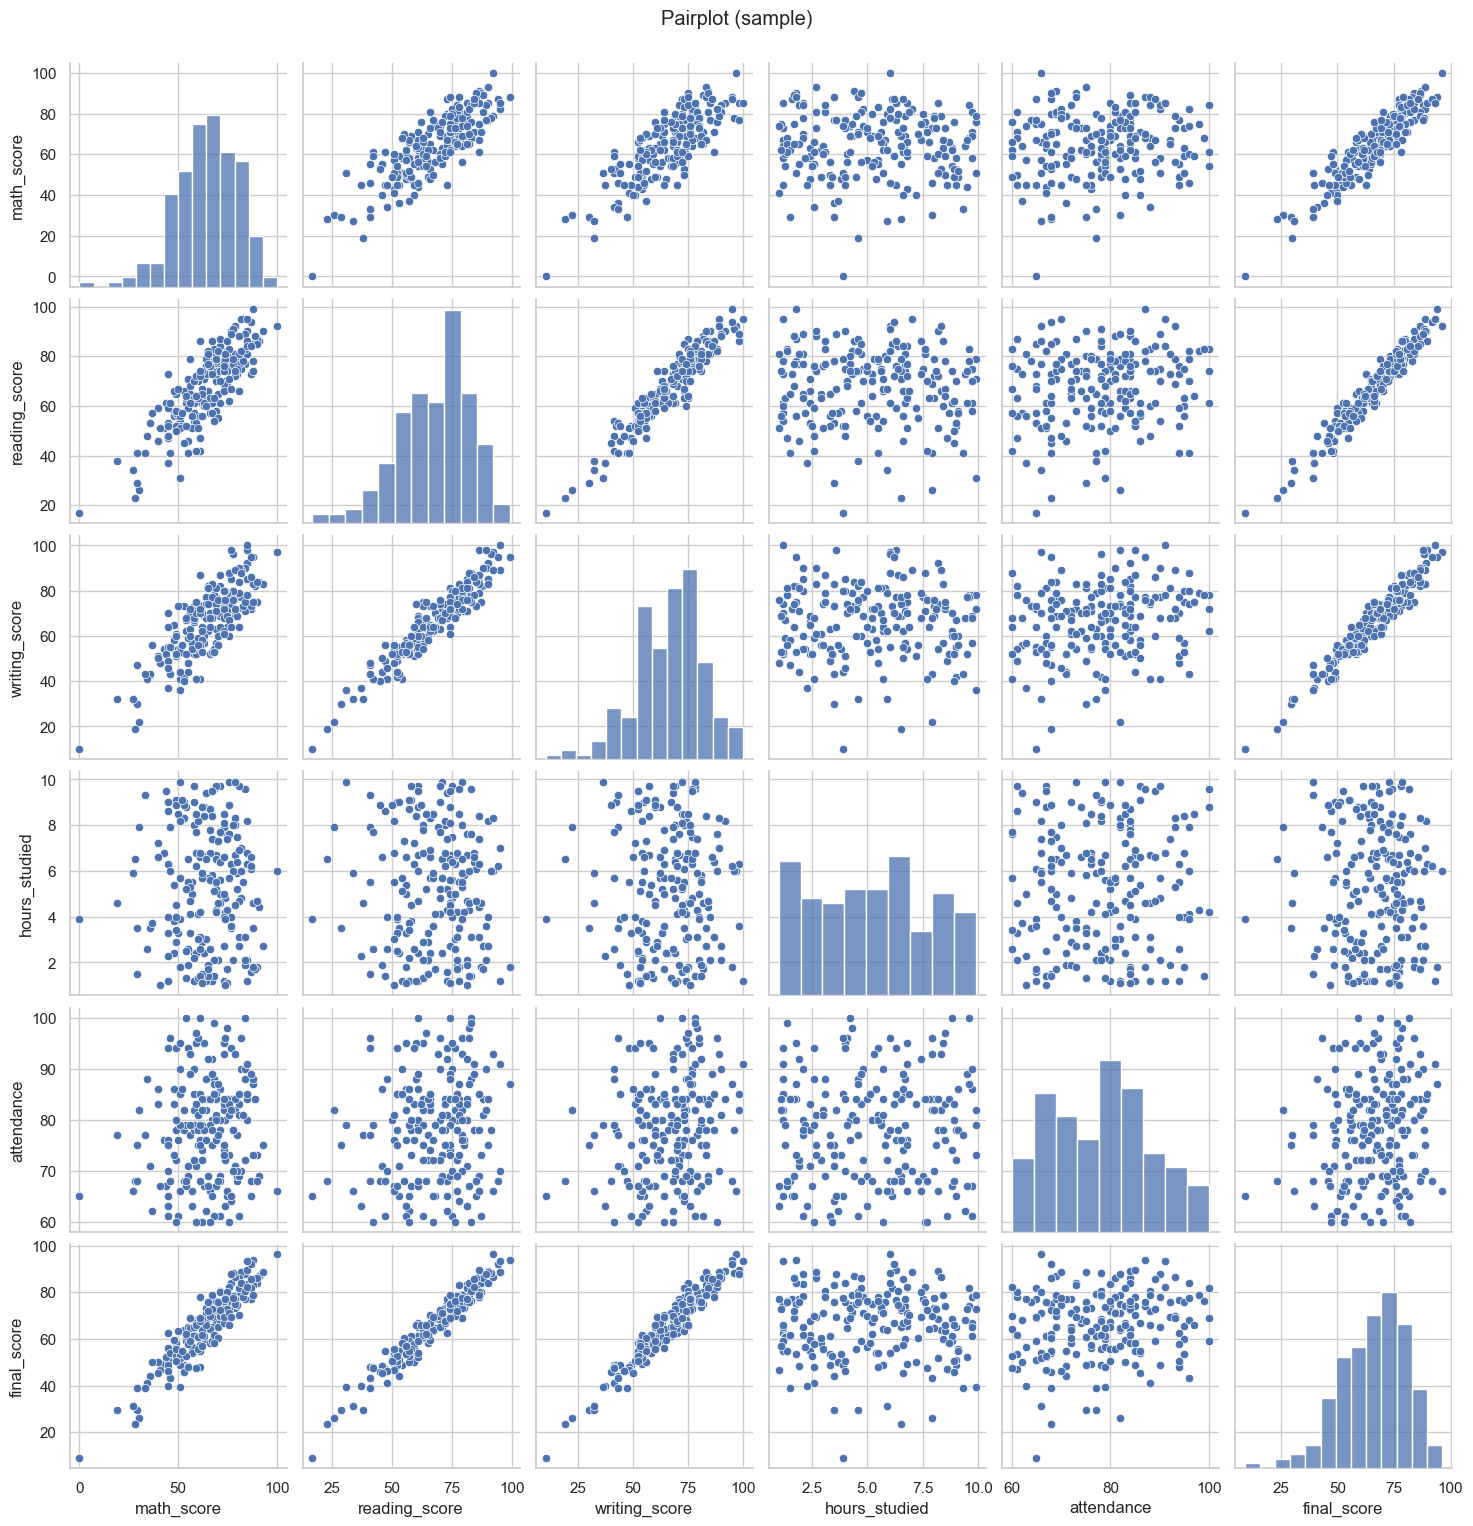

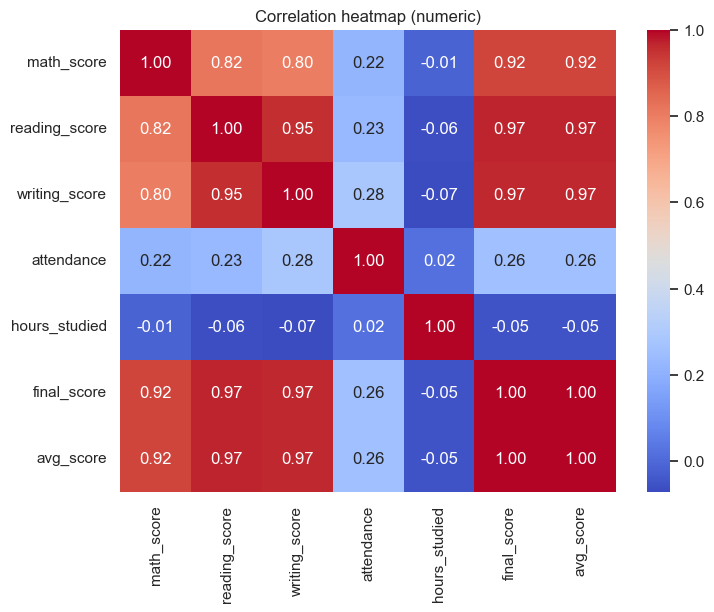

In [15]:
# 3) Exploratory Data Analysis (EDA)
# Missing values
print('\nMissing values per column:')
print(df.isnull().sum())

# Summary statistics
print('\nNumeric summary:')
display(df.describe())

# Categorical distributions
cat_cols = ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']
for col in cat_cols:
    if col in df.columns:
        print('\nValue counts for', col)
        print(df[col].value_counts())

# Distribution of target variable
if 'final_score' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['final_score'], kde=True)
    plt.title('Distribution of Final Score')
    plt.xlabel('Final Score')
    plt.show()
else:
    print('Column final_score not found. Please confirm target column name.')

# Pairplot (use sample to keep it fast)
num_cols = ['math_score','reading_score','writing_score','hours_studied','attendance','final_score']
num_cols = [c for c in num_cols if c in df.columns]
if len(num_cols) > 1:
    sample = df[num_cols].sample(min(200, len(df)), random_state=42)
    sns.pairplot(sample)
    plt.suptitle('Pairplot (sample)', y=1.02)
    plt.show()

# Correlation heatmap (numeric-only)
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation heatmap (numeric)')
plt.show()

In [4]:
# 4) Feature engineering
# Create average of the three subject scores (if present) - useful feature
score_cols = [c for c in ['math_score','reading_score','writing_score'] if c in df.columns]
if len(score_cols) > 0:
    df['avg_score'] = df[score_cols].mean(axis=1)
    print('\nCreated feature: avg_score')

# quick check
display(df.head())



Created feature: avg_score


,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,attendance,hours_studied,final_score,avg_score
0,female,group B,bachelor's degree,standard,none,72,72,74,71,4.4,72.7,72.666667
1,female,group C,some college,standard,completed,69,90,88,99,9.6,82.3,82.333333
2,female,group B,master's degree,standard,none,90,95,93,79,7.6,92.7,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,70,6.4,49.3,49.333333
4,male,group C,some college,standard,none,76,78,75,72,2.4,76.3,76.333333


In [5]:
# 5) Preprocessing: encode categorical variables and scale numeric features
# We'll use get_dummies for categorical columns (drop_first=True to avoid multicollinearity)
cat_cols_present = [c for c in cat_cols if c in df.columns]
print('Categorical columns found:', cat_cols_present)

# Create a copy to keep original df intact
df_model = df.copy()

# One-hot encode
if len(cat_cols_present) > 0:
    df_model = pd.get_dummies(df_model, columns=cat_cols_present, drop_first=True)
    print('After get_dummies, shape:', df_model.shape)

# Define X and y
if 'final_score' not in df_model.columns:
    raise ValueError('Target column final_score not found in dataframe (after renaming).')

X = df_model.drop(columns=['final_score'])
y = df_model['final_score']

# Save numeric column names for scaling
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
print('\nNumber of feature columns:', X.shape[1])

# Scale numeric columns using StandardScaler
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

print('\nFeature matrix shape:', X.shape)
print('Target shape:', y.shape)


Categorical columns found: ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course']
After get_dummies, shape: (1000, 19)

Number of feature columns: 18

Feature matrix shape: (1000, 18)
Target shape: (1000,)


In [6]:
# 6) Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (800, 18) Test shape: (200, 18)


In [7]:
# 7) Model training + evaluation helper

def evaluate_model(model, X_train, y_train, X_test, y_test, name='Model'):
    """Fits model, prints metrics, and returns trained model + predictions."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")
    return model, y_pred

# Train Linear Regression
lr = LinearRegression()
lr, y_pred_lr = evaluate_model(lr, X_train, y_train, X_test, y_test, name='LinearRegression')

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf, y_pred_rf = evaluate_model(rf, X_train, y_train, X_test, y_test, name='RandomForest')

# Train Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=200, random_state=42)
gb, y_pred_gb = evaluate_model(gb, X_train, y_train, X_test, y_test, name='GradientBoosting')

# Try XGBoost if available
try:
    import xgboost as xgb
    xg = xgb.XGBRegressor(random_state=42, n_estimators=200, verbosity=0)
    xg, y_pred_xg = evaluate_model(xg, X_train, y_train, X_test, y_test, name='XGBoost')
    xgboost_available = True
except Exception:
    print('XGBoost not installed or import failed. To install: pip install xgboost')
    xgboost_available = False


LinearRegression -> RMSE: 0.027, MAE: 0.022, R2: 1.000
RandomForest -> RMSE: 0.955, MAE: 0.129, R2: 0.996
GradientBoosting -> RMSE: 0.689, MAE: 0.138, R2: 0.998
XGBoost not installed or import failed. To install: pip install xgboost


In [8]:
# 8) Cross-validation comparison (5-fold CV RMSE)
models_for_cv = [
    ('LinearRegression', LinearRegression()),
    ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('GradientBoosting', GradientBoostingRegressor(n_estimators=200, random_state=42))
]
if xgboost_available:
    from xgboost import XGBRegressor
    models_for_cv.append(('XGBoost', XGBRegressor(random_state=42, n_estimators=200, verbosity=0)))

print('\nCross-validation RMSE (5-fold):')
for name, model in models_for_cv:
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print(f"{name}: mean RMSE = {rmse_scores.mean():.3f}, std = {rmse_scores.std():.3f}")




Cross-validation RMSE (5-fold):
LinearRegression: mean RMSE = 0.027, std = 0.000
RandomForest: mean RMSE = 0.310, std = 0.302
GradientBoosting: mean RMSE = 0.285, std = 0.224



Top 20 feature importances (RandomForest):


avg_score                                        9.981971e-01
writing_score                                    1.157852e-03
reading_score                                    2.337802e-04
math_score                                       2.058257e-04
attendance                                       7.186256e-05
hours_studied                                    6.187694e-05
gender_male                                      1.418617e-05
race_ethnicity_group B                           1.274502e-05
parental_level_of_education_high school          1.212939e-05
race_ethnicity_group E                           7.910192e-06
parental_level_of_education_some high school     7.216644e-06
lunch_standard                                   4.559460e-06
test_preparation_course_none                     4.428212e-06
race_ethnicity_group D                           3.080878e-06
race_ethnicity_group C                           2.251385e-06
parental_level_of_education_some college         1.620599e-06
parental

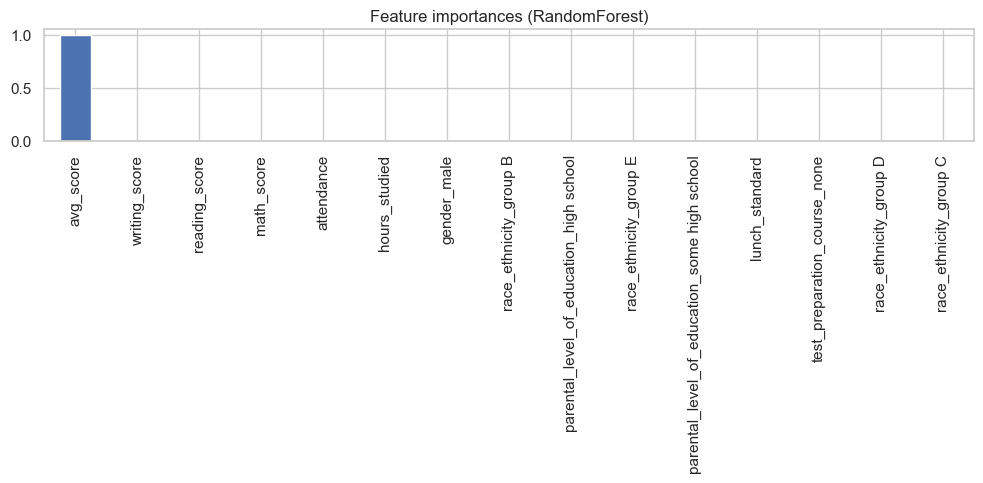


Permutation importance (LinearRegression) - may take a few seconds


avg_score                                        1.433111e-01
math_score                                       1.337358e-01
writing_score                                    1.313081e-01
reading_score                                    1.240603e-01
test_preparation_course_none                     1.428610e-07
gender_male                                      1.156197e-07
race_ethnicity_group B                           3.498763e-08
hours_studied                                    2.702251e-08
race_ethnicity_group C                           2.483100e-08
parental_level_of_education_some high school     1.146444e-08
race_ethnicity_group D                           1.139157e-08
parental_level_of_education_master's degree      3.888537e-10
race_ethnicity_group E                           3.214372e-10
parental_level_of_education_bachelor's degree   -3.822894e-10
lunch_standard                                  -5.542496e-09
parental_level_of_education_high school         -2.340368e-08
attendan


R2 scores on test set: {'LinearRegression': 0.9999967051418055, 'RandomForest': 0.9957443524984688, 'GradientBoosting': 0.9977863931797237}
Best model on test set: LinearRegression


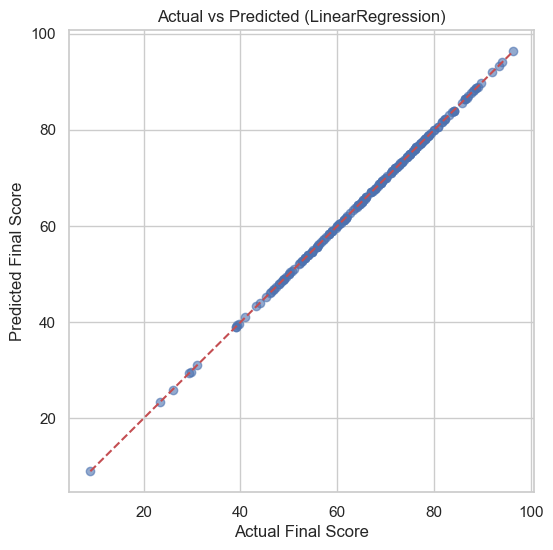

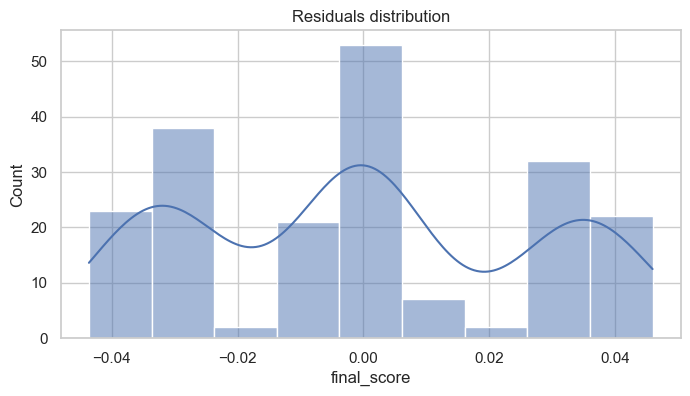

In [9]:
# 9) Feature importance (for tree-based models) + residuals + actual vs predicted
# Feature importance for RandomForest
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print('\nTop 20 feature importances (RandomForest):')
display(feat_importances.head(20))

plt.figure(figsize=(10,5))
feat_importances.head(15).plot(kind='bar')
plt.title('Feature importances (RandomForest)')
plt.tight_layout()
plt.show()

# Permutation importance for LinearRegression (gives idea for any model)
print('\nPermutation importance (LinearRegression) - may take a few seconds')
perm = permutation_importance(lr, X_test, y_test, n_repeats=20, random_state=42, n_jobs=-1)
perm_importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
display(perm_importances.head(20))

# Compare actual vs predicted for the model with highest R2 on test set
r2_scores = {
    'LinearRegression': r2_score(y_test, y_pred_lr),
    'RandomForest': r2_score(y_test, y_pred_rf),
    'GradientBoosting': r2_score(y_test, y_pred_gb)
}
if xgboost_available:
    r2_scores['XGBoost'] = r2_score(y_test, y_pred_xg)

best_model_name = max(r2_scores, key=r2_scores.get)
print('\nR2 scores on test set:', r2_scores)
print('Best model on test set:', best_model_name)

# get predictions for best model
preds_map = {'LinearRegression': y_pred_lr, 'RandomForest': y_pred_rf, 'GradientBoosting': y_pred_gb}
if xgboost_available:
    preds_map['XGBoost'] = y_pred_xg

best_preds = preds_map[best_model_name]

plt.figure(figsize=(6,6))
plt.scatter(y_test, best_preds, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Final Score')
plt.ylabel('Predicted Final Score')
plt.title(f'Actual vs Predicted ({best_model_name})')
plt.show()

# Residuals
residuals = y_test - best_preds
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title('Residuals distribution')
plt.show()


In [11]:
# 10) (Optional) GridSearch for RandomForest to improve performance - commented by default
# Uncomment and adjust param_grid if you'd like to run hyperparameter tuning.
# NOTE: grid search can be time-consuming depending on ranges.

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)
print('Best params:', grid.best_params_)
best_rf = grid.best_estimator_
best_rf, y_pred_best_rf = evaluate_model(best_rf, X_train, y_train, X_test, y_test, name='TunedRandomForest')


Best params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
TunedRandomForest -> RMSE: 0.925, MAE: 0.118, R2: 0.996


In [12]:
# 11) Save the best model and scaler for later inference
models_map = {
    'LinearRegression': lr,
    'RandomForest': rf,
    'GradientBoosting': gb
}
if xgboost_available:
    models_map['XGBoost'] = xg

best_model_obj = models_map[best_model_name]

joblib.dump(best_model_obj, f'best_model_{best_model_name}.joblib')
joblib.dump(scaler, 'scaler.joblib')
print(f"Saved best model as best_model_{best_model_name}.joblib and scaler.joblib")

Saved best model as best_model_LinearRegression.joblib and scaler.joblib


In [13]:
# 12) Inference helper: how to prepare new samples and predict

def prepare_and_predict(sample_dict, model_path=f'best_model_{best_model_name}.joblib', scaler_path='scaler.joblib'):
    """
    sample_dict: dictionary of feature_name: value for a single instance.
    IMPORTANT: keys must match original (renamed) column names before get_dummies.
    For categorical features, provide the original string value (e.g. 'female', 'standard', etc.).
    The helper will convert, one-hot encode and align columns with training set.
    """
    # Load model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    # Create a DataFrame from the input and normalize column names same way as training
    sample_df = pd.DataFrame([sample_dict])
    sample_df.columns = [c.strip().lower().replace(' ', '_').replace('/', '_') for c in sample_df.columns]

    # Add any missing numeric columns with 0 (will be scaled)
    # For robust alignment we create a df with same columns as X (preprocessed training features)
    # To do that, we need access to X.columns created earlier in the notebook. We'll assume X exists in the session.
    # If running this cell independently, re-create X (e.g., rerun earlier cells) so X.columns is available.

    global X  # ensure we refer to training feature set
    # One-hot encode the categorical columns present in the original dataset
    cat_cols_local = [c for c in ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course'] if c in df.columns]
    if len(cat_cols_local) > 0:
        sample_df = pd.get_dummies(sample_df, columns=cat_cols_local, drop_first=True)

    # Ensure all training columns are present in sample_df
    for col in X.columns:
        if col not in sample_df.columns:
            sample_df[col] = 0

    # Align column order
    sample_df = sample_df[X.columns]

    # Scale numeric columns
    num_cols_local = sample_df.select_dtypes(include=[np.number]).columns.tolist()
    sample_df[num_cols_local] = scaler.transform(sample_df[num_cols_local])

    # Predict
    pred = model.predict(sample_df)[0]
    return pred

# Example usage (using the first test row):
sample_row = X_test.iloc[0]
print('\nExample prediction (first test row) - actual vs predicted using best model:')
print('Actual:', y_test.iloc[0])
print('Predicted:', best_model_obj.predict(X_test.iloc[[0]])[0])

# Example: prepare a sample dictionary and call prepare_and_predict
# sample_input = {
#     'gender': 'female',
#     'race/ethnicity': "group B",
#     'parental level of education': "bachelor's degree",
#     'lunch': 'standard',
#     'test preparation course': 'none',
#     'math_score': 70,
#     'reading_score': 72,
#     'writing_score': 68,
#     'attendance': 90,
#     'hours_studied': 5.0
# }
# pred_example = prepare_and_predict(sample_input)
# print('Predicted Final Score for sample input:', pred_example)



Example prediction (first test row) - actual vs predicted using best model:
Actual: 87.0
Predicted: 87.00493919148039


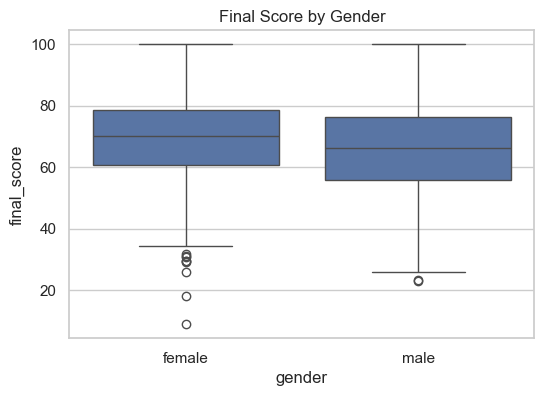

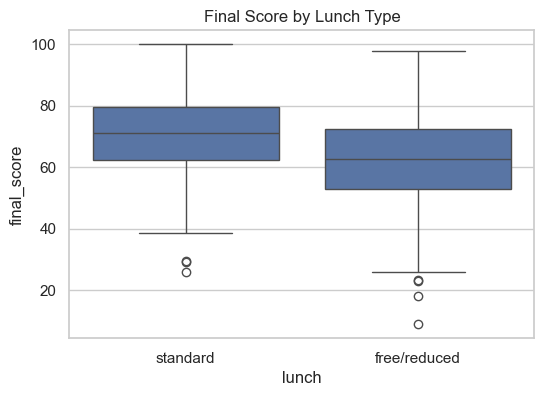

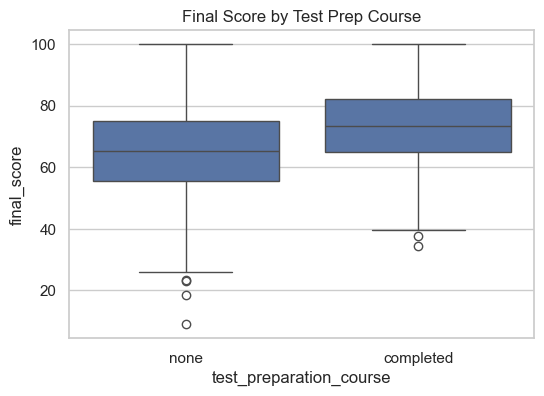

In [16]:
# 13) Boxplot: Gender vs Final Score
plt.figure(figsize=(6,4))
sns.boxplot(x='gender', y='final_score', data=df)
plt.title('Final Score by Gender')
plt.show()

# Boxplot: Lunch type vs Final Score
plt.figure(figsize=(6,4))
sns.boxplot(x='lunch', y='final_score', data=df)
plt.title('Final Score by Lunch Type')
plt.show()

# Boxplot: Test Preparation Course vs Final Score
plt.figure(figsize=(6,4))
sns.boxplot(x='test_preparation_course', y='final_score', data=df)
plt.title('Final Score by Test Prep Course')
plt.show()


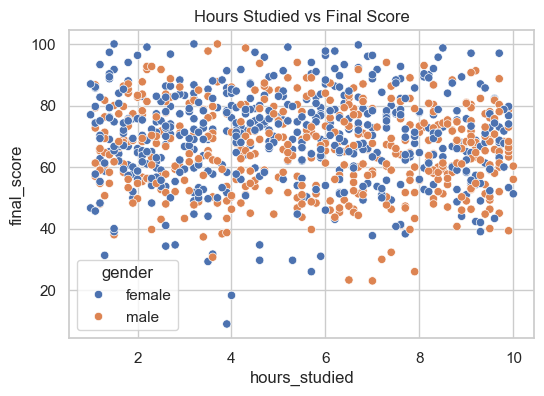

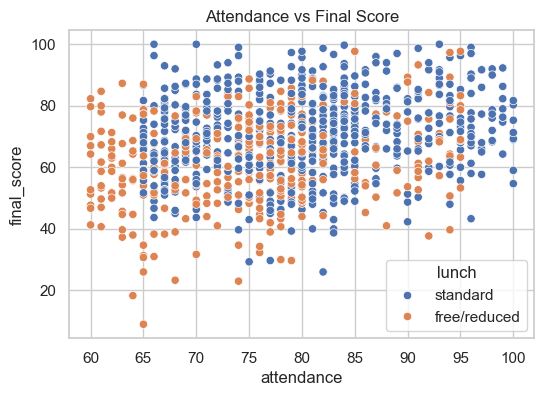

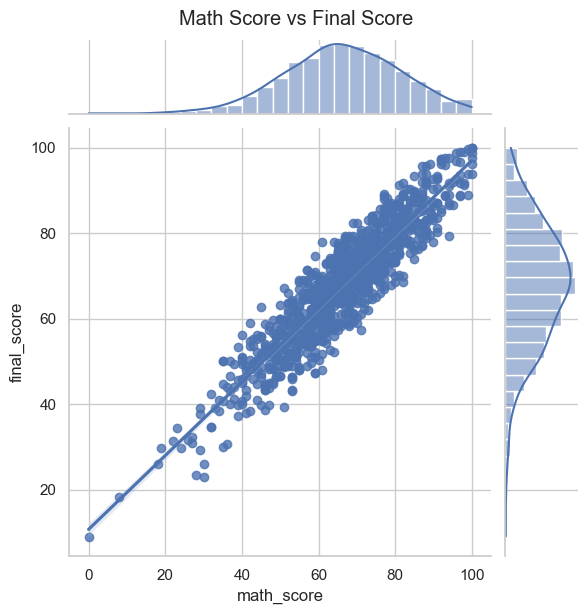

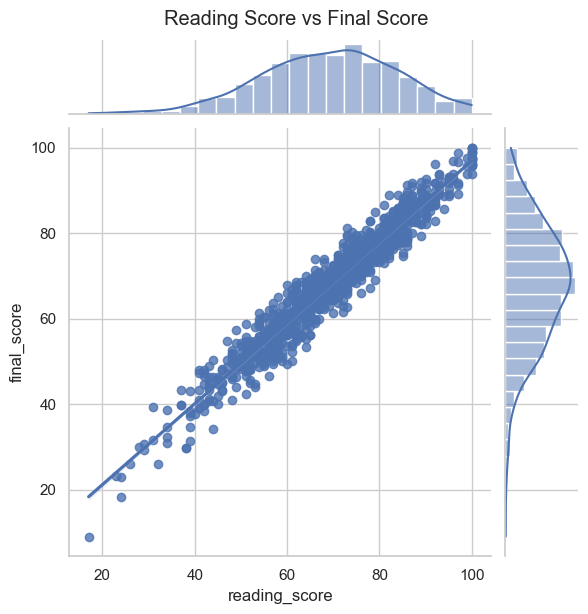

In [17]:
# 15) Scatter: Hours Studied vs Final Score
plt.figure(figsize=(6,4))
sns.scatterplot(x='hours_studied', y='final_score', hue='gender', data=df)
plt.title('Hours Studied vs Final Score')
plt.show()

# Scatter: Attendance vs Final Score
plt.figure(figsize=(6,4))
sns.scatterplot(x='attendance', y='final_score', hue='lunch', data=df)
plt.title('Attendance vs Final Score')
plt.show()

# Jointplot: Math score vs Final Score
sns.jointplot(x='math_score', y='final_score', data=df, kind='reg', height=6)
plt.suptitle('Math Score vs Final Score', y=1.02)
plt.show()

# Jointplot: Reading score vs Final Score
sns.jointplot(x='reading_score', y='final_score', data=df, kind='reg', height=6)
plt.suptitle('Reading Score vs Final Score', y=1.02)
plt.show()


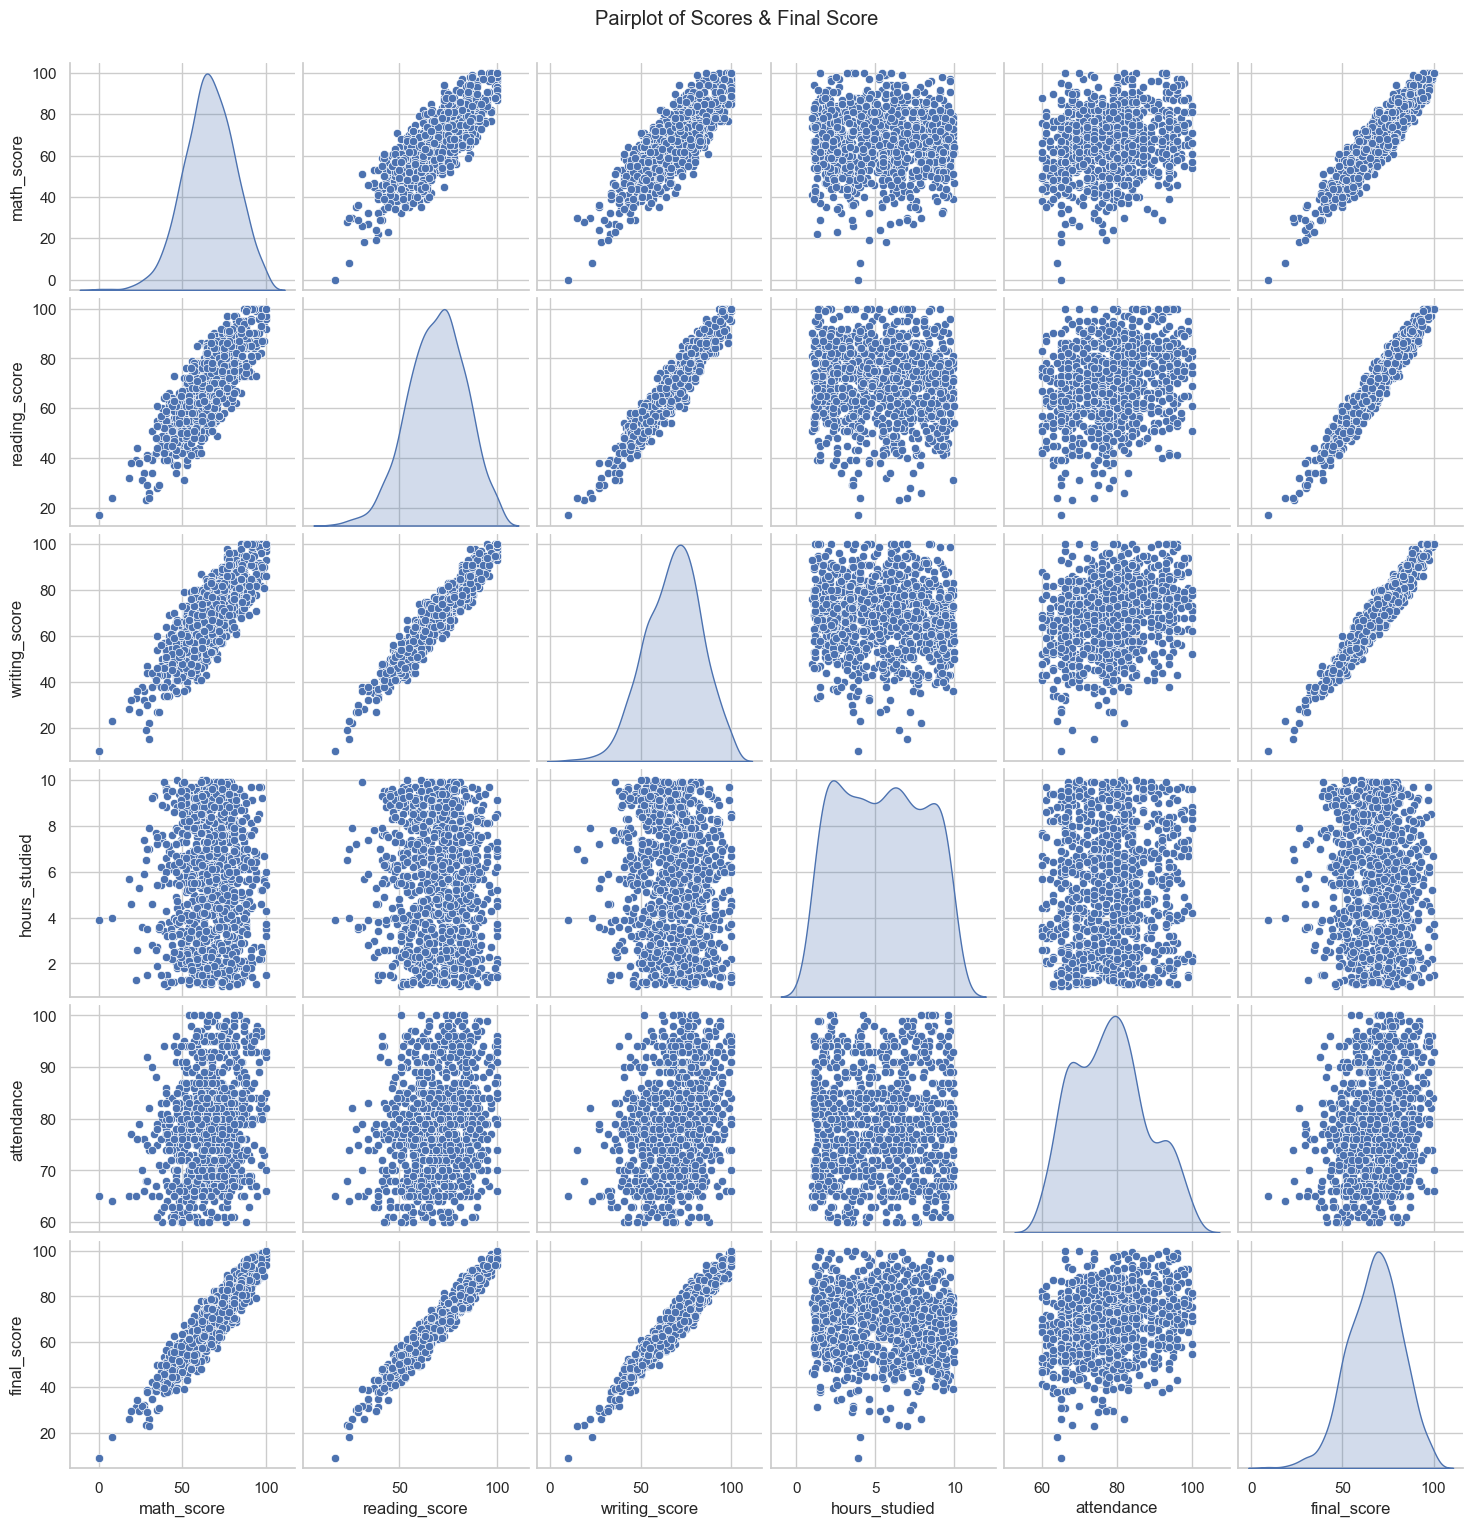

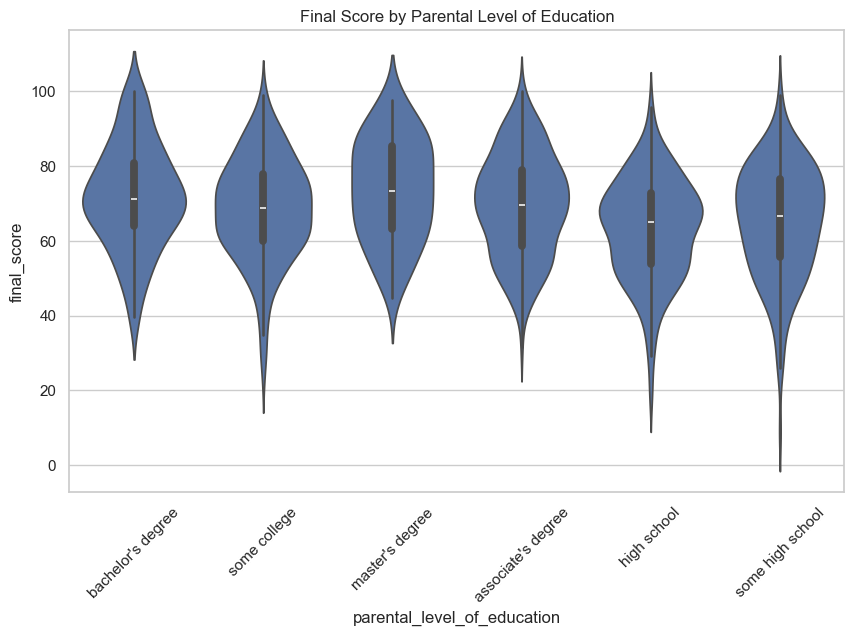

In [18]:
# 16) Pairplot of important features
important_cols = ['math_score', 'reading_score', 'writing_score', 'hours_studied', 'attendance', 'final_score']
sns.pairplot(df[important_cols], diag_kind='kde')
plt.suptitle('Pairplot of Scores & Final Score', y=1.02)
plt.show()

# Violinplot: Parental education vs Final Score
plt.figure(figsize=(10,6))
sns.violinplot(x='parental_level_of_education', y='final_score', data=df)
plt.xticks(rotation=45)
plt.title('Final Score by Parental Level of Education')
plt.show()


🔹 1. Decision Tree Regressor

In [19]:
from sklearn.tree import DecisionTreeRegressor

# Train-Test Split (reuse X_train, X_test, y_train, y_test)
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

# Predictions
y_pred_dt = dt.predict(X_test)

# Evaluation
print("Decision Tree Regressor R2:", r2_score(y_test, y_pred_dt))
print("Decision Tree Regressor MSE:", mean_squared_error(y_test, y_pred_dt))


Decision Tree Regressor R2: 0.997616846020381
Decision Tree Regressor MSE: 0.51095


🔹 2. Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))


Random Forest R2: 0.9957443524984688
Random Forest MSE: 0.912414014999999


🔹 3. Support Vector Regressor (SVR)

In [21]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# SVR requires scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()

svr = SVR(kernel='rbf')
svr.fit(X_train_scaled, y_train_scaled)

y_pred_svr_scaled = svr.predict(X_test_scaled)
y_pred_svr = scaler_y.inverse_transform(y_pred_svr_scaled.reshape(-1,1))

print("SVR R2:", r2_score(y_test, y_pred_svr))
print("SVR MSE:", mean_squared_error(y_test, y_pred_svr))

SVR R2: 0.9518758255937739
SVR MSE: 10.317859073794628


🔹 4. K-Nearest Neighbors Regressor

In [22]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

print("KNN R2:", r2_score(y_test, y_pred_knn))
print("KNN MSE:", mean_squared_error(y_test, y_pred_knn))

KNN R2: 0.9704431070908603
KNN MSE: 6.3370200000000025


🔹 5. Model Comparison Table

In [25]:
# Refit model as Linear Regression before results
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Results DataFrame
results = {
    "Model": ["Linear Regression", "Decision Tree", "Random Forest", "SVR", "KNN"],
    "R2 Score": [
        r2_score(y_test, y_pred),
        r2_score(y_test, y_pred_dt),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_svr),
        r2_score(y_test, y_pred_knn)
    ],
    "MSE": [
        mean_squared_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred_dt),
        mean_squared_error(y_test, y_pred_rf),
        mean_squared_error(y_test, y_pred_svr),
        mean_squared_error(y_test, y_pred_knn)
    ]
}

results_df = pd.DataFrame(results)
print("Model Performance Results:")
print(results_df)


Model Performance Results:
               Model  R2 Score        MSE
0  Linear Regression  0.999997   0.000706
1      Decision Tree  0.997617   0.510950
2      Random Forest  0.995744   0.912414
3                SVR  0.951876  10.317859
4                KNN  0.970443   6.337020


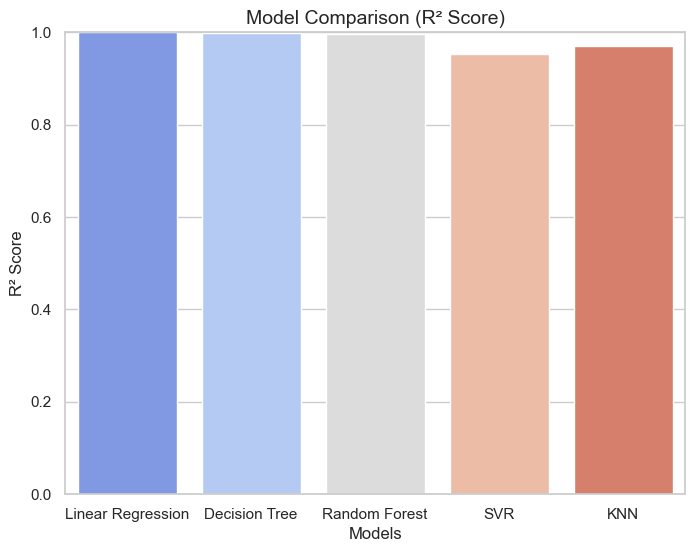

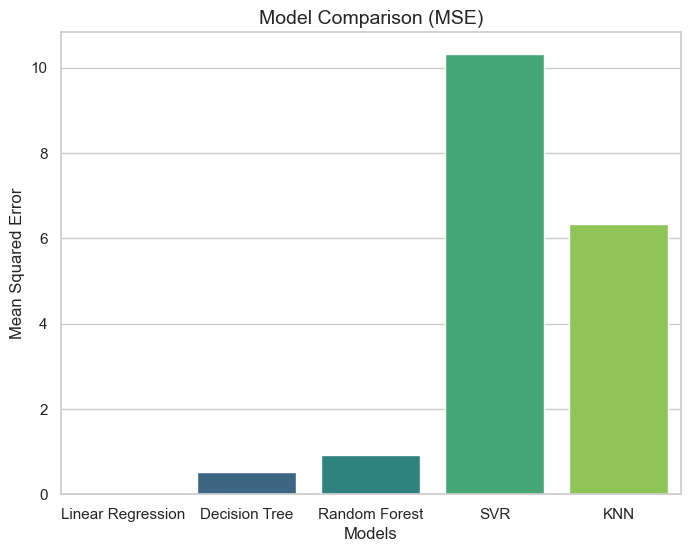

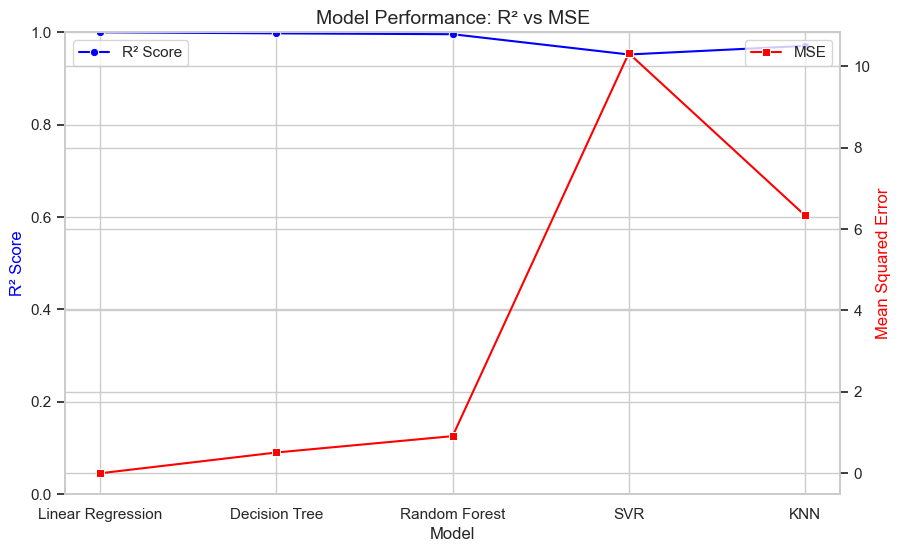

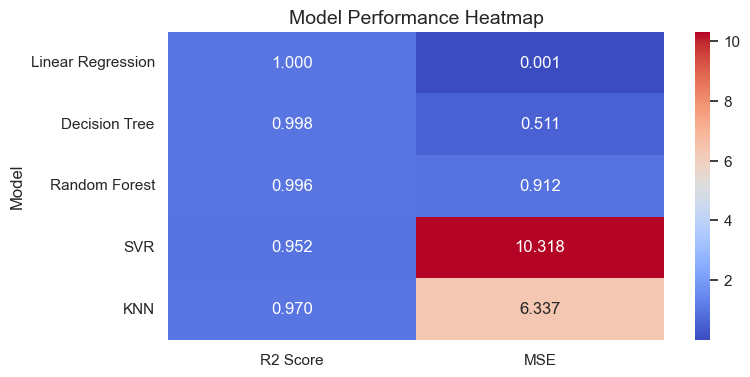

In [26]:
# -----------------------------
# 📊 Visualizations
# -----------------------------

# Barplot for R² Score
plt.figure(figsize=(8,6))
sns.barplot(
    data=results_df,
    x="Model", y="R2 Score",
    hue="Model", legend=False,
    palette="coolwarm"
)
plt.title("Model Comparison (R² Score)", fontsize=14)
plt.ylabel("R² Score")
plt.xlabel("Models")
plt.ylim(0,1)
plt.show()

# Barplot for MSE
plt.figure(figsize=(8,6))
sns.barplot(
    data=results_df,
    x="Model", y="MSE",
    hue="Model", legend=False,
    palette="viridis"
)
plt.title("Model Comparison (MSE)", fontsize=14)
plt.ylabel("Mean Squared Error")
plt.xlabel("Models")
plt.show()

# Combined Line Plot (R² vs MSE)
fig, ax1 = plt.subplots(figsize=(10,6))

sns.lineplot(
    data=results_df, x="Model", y="R2 Score",
    marker="o", color="blue", ax=ax1, label="R² Score"
)
ax1.set_ylabel("R² Score", color="blue")
ax1.set_ylim(0,1)

ax2 = ax1.twinx()
sns.lineplot(
    data=results_df, x="Model", y="MSE",
    marker="s", color="red", ax=ax2, label="MSE"
)
ax2.set_ylabel("Mean Squared Error", color="red")

plt.title("Model Performance: R² vs MSE", fontsize=14)
plt.show()

# Heatmap of results
plt.figure(figsize=(8,4))
sns.heatmap(
    results_df.set_index("Model"),
    annot=True, fmt=".3f", cmap="coolwarm", cbar=True
)
plt.title("Model Performance Heatmap", fontsize=14)
plt.show()


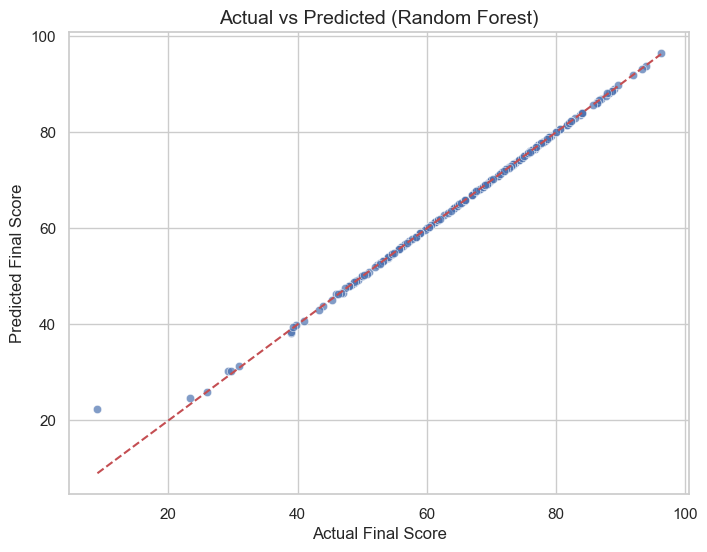

In [27]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect fit line
plt.title("Actual vs Predicted (Random Forest)", fontsize=14)
plt.xlabel("Actual Final Score")
plt.ylabel("Predicted Final Score")
plt.show()

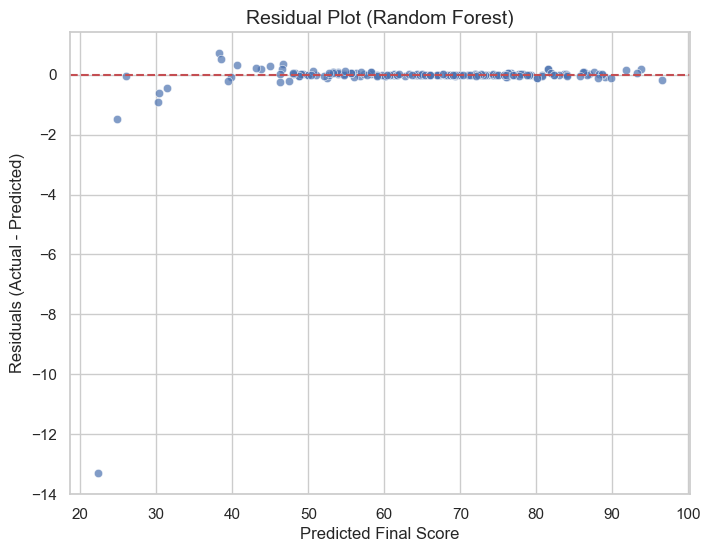

In [28]:
residuals = y_test - y_pred_rf

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred_rf, y=residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot (Random Forest)", fontsize=14)
plt.xlabel("Predicted Final Score")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()


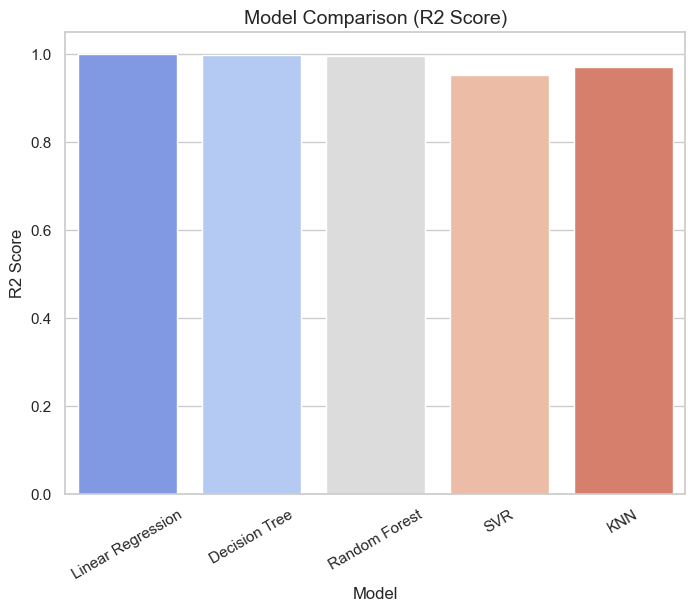

In [29]:
plt.figure(figsize=(8,6))
sns.barplot(
    x="Model", 
    y="R2 Score", 
    data=results_df, 
    hue="Model",       # add hue to avoid warning
    legend=False,      # remove duplicate legend
    palette="coolwarm" # keep same colors
)
plt.title("Model Comparison (R2 Score)", fontsize=14)
plt.ylabel("R2 Score")
plt.xticks(rotation=30)
plt.show()


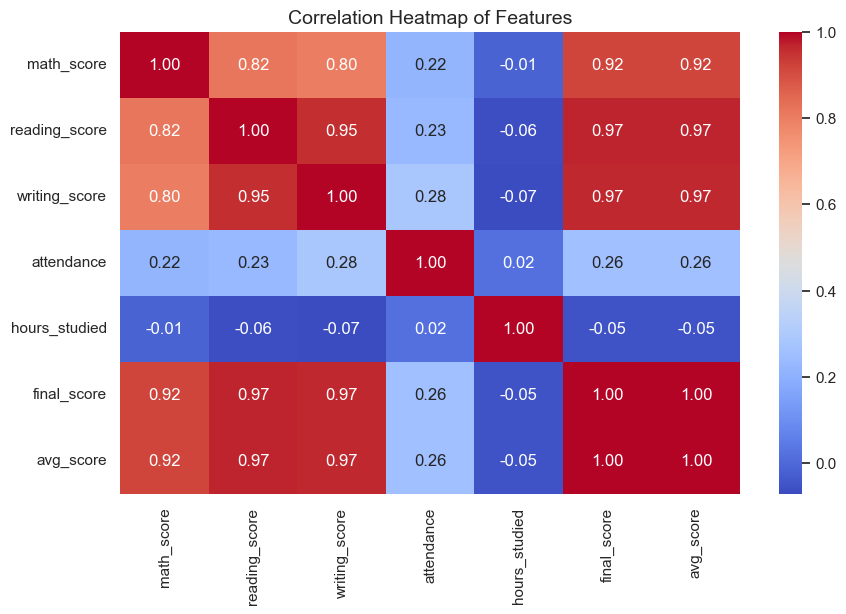

In [31]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features", fontsize=14)
plt.show()